In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential, Model
from keras.layers.core import Dropout, Activation
from keras import Input
from keras.layers import LSTM, Conv1D, Dense
from keras.models import load_model
import keras
import seaborn as sns

In [29]:
data = pd.read_csv('data_badminton.csv')
data

,track,frames,second,left_x,left_y,right_x,right_y,draw
0,7_1_2_9_10_back2_track_0,0,0,-1.173543,-0.978265,1.198401,-1.080769,0
1,7_1_2_9_10_back2_track_0,1,0,-1.173718,-0.978345,1.198432,-1.080836,0
2,7_1_2_9_10_back2_track_0,2,0,-1.157852,-0.971772,1.212083,-1.080867,0
3,7_1_2_9_10_back2_track_0,3,0,-1.172914,-0.971658,1.199090,-1.074577,0
4,7_1_2_9_10_back2_track_0,4,0,-1.173402,-0.978236,1.211824,-1.081002,0
...,...,...,...,...,...,...,...,...
44267,6_171834_back1_track_5,339,11,0.163240,-1.395213,-0.425735,-1.335000,0
44268,6_171834_back1_track_5,340,11,0.142895,-1.414455,-0.424953,-1.352235,0
44269,6_171834_back1_track_5,341,11,0.529217,-1.375982,-0.541664,-1.334431,0
44270,6_171834_back1_track_5,342,11,1.423309,-1.353609,-0.629641,-1.311030,0


In [30]:
print(f'shape = {data.shape}')
print(f'train shape = {data.shape[0]*0.67, data.shape[1]}')
print(f'test shape = {data.shape[0]*0.33, data.shape[1]}')

shape = (44272, 8)
train shape = (29662.24, 8)
test shape = (14609.76, 8)


In [31]:
#split to test and train data

X = data.drop(columns=['draw'])
y = data['draw']

train = data[:30146]
test = data[30146:]

In [32]:
train

,track,frames,second,left_x,left_y,right_x,right_y,draw
0,7_1_2_9_10_back2_track_0,0,0,-1.173543,-0.978265,1.198401,-1.080769,0
1,7_1_2_9_10_back2_track_0,1,0,-1.173718,-0.978345,1.198432,-1.080836,0
2,7_1_2_9_10_back2_track_0,2,0,-1.157852,-0.971772,1.212083,-1.080867,0
3,7_1_2_9_10_back2_track_0,3,0,-1.172914,-0.971658,1.199090,-1.074577,0
4,7_1_2_9_10_back2_track_0,4,0,-1.173402,-0.978236,1.211824,-1.081002,0
...,...,...,...,...,...,...,...,...
30141,1_1234_back4_track_0,161,5,0.644798,-1.127966,-0.865200,-1.184687,0
30142,1_1234_back4_track_0,162,5,0.624807,-1.189486,-0.884919,-1.193501,0
30143,1_1234_back4_track_0,163,5,0.697994,-1.176852,-0.866488,-1.211607,0
30144,1_1234_back4_track_0,164,5,0.723391,-1.183704,-0.867228,-1.202621,0


In [33]:
test

,track,frames,second,left_x,left_y,right_x,right_y,draw
30146,1_1234_back4_track_0,166,5,0.597095,-1.131106,-0.836925,-1.171823,0
30147,1_1234_back4_track_0,167,5,0.630751,-1.166340,-0.848539,-1.186725,0
30148,1_1234_back4_track_0,168,5,0.682312,-1.179916,-0.848004,-1.213227,0
30149,1_1234_back4_track_0,169,5,0.578645,-1.135673,-0.875160,-1.221004,0
30150,1_1234_back4_track_0,170,5,0.604500,-1.152576,-0.848466,-1.186698,0
...,...,...,...,...,...,...,...,...
44267,6_171834_back1_track_5,339,11,0.163240,-1.395213,-0.425735,-1.335000,0
44268,6_171834_back1_track_5,340,11,0.142895,-1.414455,-0.424953,-1.352235,0
44269,6_171834_back1_track_5,341,11,0.529217,-1.375982,-0.541664,-1.334431,0
44270,6_171834_back1_track_5,342,11,1.423309,-1.353609,-0.629641,-1.311030,0


In [34]:
def data_creating(N, dataset, coord):
    frames = int(N*30)
    dataX, dataY = [], []
    for name in dataset['track'].unique():
        for i in range(len(dataset[dataset['track'] == name])-frames-1):
            df = dataset[dataset['track'] == name].copy()
            df.index = df[df['track'] == name]['frames']
            a = df.iloc[i:(i+frames), coord]
            dataX.append(a)
            dataY.append(df.iloc[(i+frames), coord])
    return np.array(dataX), np.array(dataY)


Посмотрим на предсказание на 3 секунды для левой ноги:

Посмотрим на координату x:

In [35]:
x_train3, y_train3 = data_creating(3, train, 3)
x_test3, y_test3 = data_creating(3, test, 3)

In [36]:
x_train3 = np.reshape(x_train3, (x_train3.shape[0], 1, x_train3.shape[1]))
x_test3 = np.reshape(x_test3, (x_test3.shape[0], 1, x_test3.shape[1]))

In [37]:
print(f"X_train shape = {x_train3.shape}")
print(f"y_train shape = {y_train3.shape}")
print(f"X_test shape = {x_test3.shape}")
print(f"y_test shape =  {y_test3.shape}")

X_train shape = (22411, 1, 90)
y_train shape = (22411,)
X_test shape = (11214, 1, 90)
y_test shape =  (11214,)


Модель

In [38]:
model3 = Sequential()
model3.add(LSTM(20, input_shape=(1,90)))
model3.add(Dense(1))
model3.compile(loss='mean_squared_error', optimizer='adam')
model3.fit(x_train3, y_train3, epochs=30, batch_size=4, verbose=2)

Epoch 1/30
5603/5603 - 15s - loss: 0.1202 - 15s/epoch - 3ms/step
Epoch 2/30
5603/5603 - 12s - loss: 0.0835 - 12s/epoch - 2ms/step
Epoch 3/30
5603/5603 - 12s - loss: 0.0772 - 12s/epoch - 2ms/step
Epoch 4/30
5603/5603 - 12s - loss: 0.0740 - 12s/epoch - 2ms/step
Epoch 5/30
5603/5603 - 13s - loss: 0.0719 - 13s/epoch - 2ms/step
Epoch 6/30
5603/5603 - 12s - loss: 0.0700 - 12s/epoch - 2ms/step
Epoch 7/30
5603/5603 - 13s - loss: 0.0689 - 13s/epoch - 2ms/step
Epoch 8/30
5603/5603 - 12s - loss: 0.0676 - 12s/epoch - 2ms/step
Epoch 9/30
5603/5603 - 13s - loss: 0.0668 - 13s/epoch - 2ms/step
Epoch 10/30
5603/5603 - 13s - loss: 0.0654 - 13s/epoch - 2ms/step
Epoch 11/30
5603/5603 - 13s - loss: 0.0654 - 13s/epoch - 2ms/step
Epoch 12/30
5603/5603 - 13s - loss: 0.0638 - 13s/epoch - 2ms/step
Epoch 13/30
5603/5603 - 12s - loss: 0.0640 - 12s/epoch - 2ms/step
Epoch 14/30
5603/5603 - 12s - loss: 0.0631 - 12s/epoch - 2ms/step
Epoch 15/30
5603/5603 - 12s - loss: 0.0624 - 12s/epoch - 2ms/step
Epoch 16/30
5603/56

Визуализация модели:

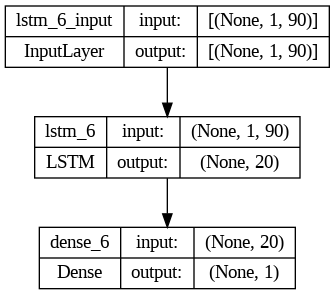

In [40]:
from keras.utils.vis_utils import plot_model
plot_model(model3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Метрики:

In [44]:
from sklearn.metrics import mean_absolute_error
y_pred3 = model3.predict(x_test3)

print(f"MAE = {mean_squared_error(y_test3, y_pred3)}")

351/351 [==============================] - 1s 2ms/step
MAE = 0.06972026719801484


Визуализация:

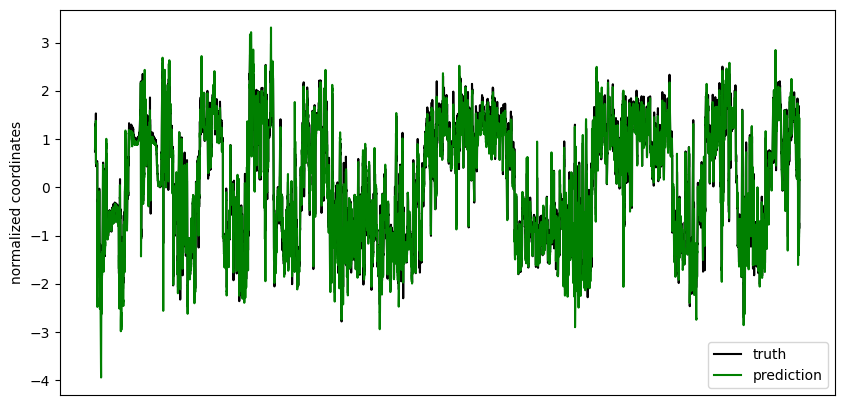

In [45]:
fig, axes = plt.subplots(figsize=(10, 5))
plt.plot(np.arange(len(y_test3)), y_pred3, color='k', label='truth')
plt.plot(np.arange(len(y_test3)), y_test3, color='green', label='prediction')
plt.legend()
plt.ylabel("normalized coordinates", fontsize=10)
plt.tick_params(
    axis='x',         
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False) 

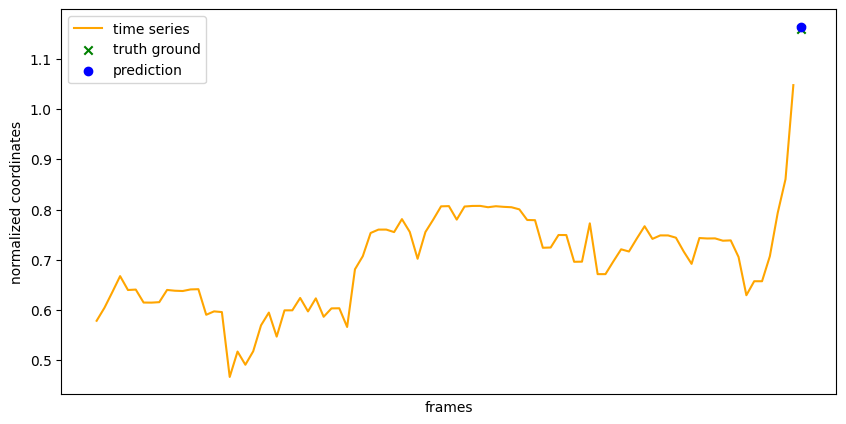

In [48]:
fig, axes = plt.subplots(figsize=(10, 5))
plt.plot(np.arange(len(x_test3[3][0])), x_test3[3][0], color='orange', label='time series')
plt.scatter(x = len(x_test3[0][0]), y = y_test3[3], marker='x', color='g', label='truth ground')
plt.scatter(x = len(x_test3[0][0]), y = y_pred3[3], color='b', label='prediction')
plt.legend()
plt.xlabel("frames", fontsize=10)
plt.ylabel("normalized coordinates", fontsize=10)
plt.tick_params(
    axis='x',         
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False) 

Посмотрим на координату y:

In [52]:
x_train3_y, y_train3_y = data_creating(3, train, 4)
x_test3_y, y_test3_y = data_creating(3, test, 4)

In [53]:
x_train3_y = np.reshape(x_train3_y, (x_train3_y.shape[0], 1, x_train3_y.shape[1]))
x_test3_y = np.reshape(x_test3_y, (x_test3_y.shape[0], 1, x_test3_y.shape[1]))

In [54]:
model3_y = Sequential()
model3_y.add(LSTM(20, input_shape=(1,90)))
model3_y.add(Dense(1))
model3_y.compile(loss='mean_squared_error', optimizer='adam')
model3_y.fit(x_train3_y, y_train3_y, epochs=30, batch_size=2, verbose=2)

Epoch 1/30
11206/11206 - 27s - loss: 0.0099 - 27s/epoch - 2ms/step
Epoch 2/30
11206/11206 - 24s - loss: 0.0065 - 24s/epoch - 2ms/step
Epoch 3/30
11206/11206 - 24s - loss: 0.0059 - 24s/epoch - 2ms/step
Epoch 4/30
11206/11206 - 23s - loss: 0.0056 - 23s/epoch - 2ms/step
Epoch 5/30
11206/11206 - 24s - loss: 0.0053 - 24s/epoch - 2ms/step
Epoch 6/30
11206/11206 - 23s - loss: 0.0052 - 23s/epoch - 2ms/step
Epoch 7/30
11206/11206 - 23s - loss: 0.0051 - 23s/epoch - 2ms/step
Epoch 8/30
11206/11206 - 24s - loss: 0.0050 - 24s/epoch - 2ms/step
Epoch 9/30
11206/11206 - 24s - loss: 0.0050 - 24s/epoch - 2ms/step
Epoch 10/30
11206/11206 - 24s - loss: 0.0048 - 24s/epoch - 2ms/step
Epoch 11/30
11206/11206 - 24s - loss: 0.0047 - 24s/epoch - 2ms/step
Epoch 12/30
11206/11206 - 24s - loss: 0.0046 - 24s/epoch - 2ms/step
Epoch 13/30
11206/11206 - 24s - loss: 0.0046 - 24s/epoch - 2ms/step
Epoch 14/30
11206/11206 - 24s - loss: 0.0045 - 24s/epoch - 2ms/step
Epoch 15/30
11206/11206 - 23s - loss: 0.0046 - 23s/epoch 

Метрики:

In [55]:
from sklearn.metrics import mean_absolute_error
y_pred3_y = model3.predict(x_test3_y)

print(f"MAE = {mean_squared_error(y_test3_y, y_pred3_y)}")

351/351 [==============================] - 1s 2ms/step
MAE = 0.006189585910471377


Визуализация:

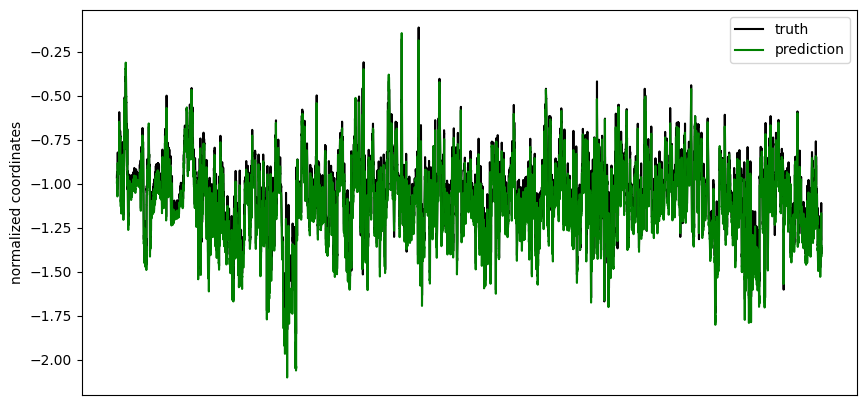

In [56]:
fig, axes = plt.subplots(figsize=(10, 5))
plt.plot(np.arange(len(y_test3_y)), y_pred3_y, color='k', label='truth')
plt.plot(np.arange(len(y_test3_y)), y_test3_y, color='green', label='prediction')
plt.legend()
plt.ylabel("normalized coordinates", fontsize=10)
plt.tick_params(
    axis='x',         
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False) 

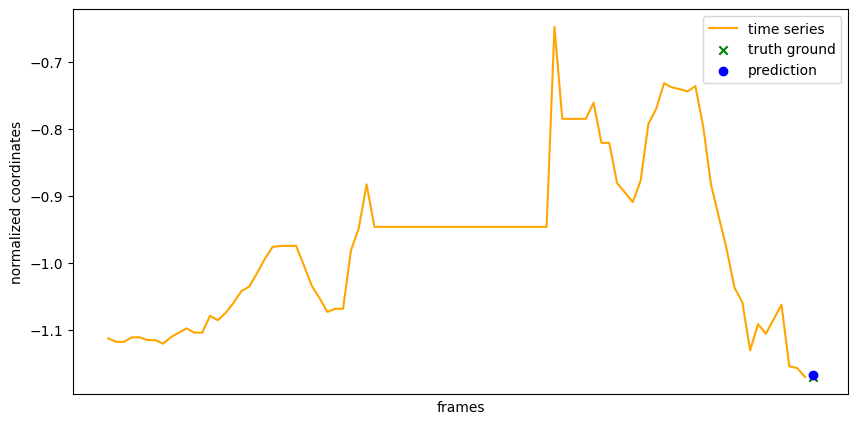

In [65]:
fig, axes = plt.subplots(figsize=(10, 5))
plt.plot(np.arange(len(x_test3_y[70][0])), x_test3_y[70][0], color='orange', label='time series')
plt.scatter(x = len(x_test3_y[0][0]), y = y_test3_y[70], marker='x', color='g', label='truth ground')
plt.scatter(x = len(x_test3_y[0][0]), y = y_pred3_y[70], color='b', label='prediction')
plt.legend()
plt.xlabel("frames", fontsize=10)
plt.ylabel("normalized coordinates", fontsize=10)
plt.tick_params(
    axis='x',         
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False) 